# Troterization

  Un operador de la forma $e^{(\hat{A} + \hat{B})}$, donde los operadore $\hat{A}$ y $\hat{B}$ no conmutan $ [\hat{A} + \hat{B}]\neq 0$, por lo que

 $e^{(\hat{A} + \hat{B})}\neq e^{\hat{A}}e^{\hat{B}}$.

 Sin embargo, se puede tomar como aproximación

 $e^{(\hat{A} + \hat{B})}\approx (e^{\hat{A}/n}e^{\hat{B}/n})^n$.

 La cuál converge al valor exacto cuando $n \to \infty$


## Modelo de Ising

$\hat{H}= -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z + b \sum_i \sigma_i^x$

La evolución de un estado inicial $\ket{\psi (0)}$ bajo este Hamiltoniano es:

$\ket{\psi (t)}= e^{-i\hat{H}t}\ket{\psi (0)}= e^{-i(-J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z + b \sum_i \sigma_i^x)}t$.

Si usamos la aproximación de trotte

$\ket{\psi (t)}=(e^{-i(-J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z)t/n}e^{-i(b \sum_i \sigma_i^x)t/n})^n$


In [1]:
include("quantum.jl")
using .quantum

In [2]:
using LinearAlgebra

In [3]:

    J = 2
    b = 1.4
    n = 8    #número de qubits
    

    Op= Dict(1 => -kron(Z, Z),
            2 => X)
    
    
    function evolution_operator(Op, alpha, ns, t)
        return exp(-im * alpha/ns * Op * t)
    end
    function evolution_system(psi, Op, ns, t)
        Uz = evolution_operator(Op[1], J, ns, t)
        Ux = evolution_operator(Op[2], b, ns, t)
        for i in 1:ns
            for k in 0:n-1
                apply_unitary!(psi, Ux, 2^k)
            end
            for j in 0:n-2
                apply_unitary!(psi, Uz, 2^j + 2^(j+1))
            end
        end

        return psi
        
    end

     H= Ising(n, b, J)
    function evolution_operator_H(t)
        return exp(-im * t * H)   
    end
    function evolution_system_H(psi, t)
        U = evolution_operator_H(t)
        new_psi= U * psi
        return new_psi
    end


evolution_system_H (generic function with 1 method)

## Elegimos un estado arbitrario

In [4]:
state= random_state(2^n)
function copies_states(nc)
    copies= [copy(state) for i in 1:nc]
    return copies
end

copies_states (generic function with 1 method)

## Funciones para hacer la evolución con trotter y obtener el valor esperado de una partícula 

In [5]:
function trotter_evolution(psi_initial, ns, delta_t, t_f)
    nc=Int(t_f/delta_t)
    psi= copies_states(nc)
    resultados= Vector{Any}(undef, nc)

    Threads.@threads for i in 1:nc
        t = i * delta_t
        resultados[i]= evolution_system(psi[i], Op, ns, t)
    end

    return resultados

    
end

trotter_evolution (generic function with 1 method)

In [6]:
function evolution_H(psi_initial, delta_t, t_f)
    N=Int(t_f/delta_t)
    resultados_H= Vector{Any}(undef, N)

    Threads.@threads for i in 1:N
        t = i * delta_t
        resultados_H[i]= evolution_system_H(psi_initial,  t)
    end

    return resultados_H

    
end

evolution_H (generic function with 1 method)

In [7]:
function valores_esperado(states, observable)
    state_r = []
    
    for i in 1:length(states)
        state = states[i]
        state_tr = partial_trace(state, 1)
        push!(state_r, state_tr)
    end

    # Calcular la traza del producto ρ * observable para cada ρ en state_r
    val_esp = [real(tr(ρ * observable)) for ρ in state_r]
    return val_esp
end


valores_esperado (generic function with 1 method)

## Resultados

### Evolución de un estado inicial cambiando el número de pasos y el tiempo fijo 

In [8]:
delta=0.1

state_copy= copies_states(1)[1]
state_delta=evolution_system_H(state_copy, delta)

256-element Vector{Complex}:
    0.09626713663572352 + 0.01806353047160546im
    0.05259027500719988 - 0.0021631994154498874im
  -0.015624398232309534 - 0.005048216524859077im
   0.006942761505558481 + 0.041408214681264974im
   0.014329080009211492 - 0.05625023288748867im
  -0.007199730888558971 + 0.0400522060583747im
    0.03661582383197486 + 0.08912735076594369im
 -0.0034372135085871795 + 0.09822078443969312im
   0.015848907026372195 - 0.0002635687024713164im
   0.006349288965362226 + 0.050488924073569474im
                        ⋮
   0.026605481565151093 - 0.08477985791802806im
   0.020947088773489726 + 0.042434344542032466im
   -0.04822486148591711 + 0.015090545538292418im
   0.022962964323229588 - 0.09496198463977061im
  -0.029741001922627713 + 0.0721845438782262im
   -0.01011461359138285 - 0.05613507337643835im
  -0.006230063256138323 - 0.1315373076776812im
    -0.0381582157557757 + 0.011404528008243372im
 -0.0018184221186232953 - 0.07217085842580882im

In [9]:
N=50:50:1000
result_steps= [norm(trotter_evolution(state, ns, delta, delta )[1]- state_delta) for ns in N]


20-element Vector{Float64}:
 0.0019618209787109746
 0.0009809364357923416
 0.00065396371399651
 0.0004904751148968116
 0.00039238122170482753
 0.00032698498313397007
 0.0002802732311501534
 0.0002452393329977206
 0.000217990695459146
 0.0001961917537688556
 0.00017835623504156944
 0.00016349328829965787
 0.0001509169384700483
 0.00014013720251644654
 0.00013079475909257547
 0.00012262011679986371
 0.00011540719381175941
 0.00010899570409306456
 0.00010325910592548699
 9.80961658988241e-5

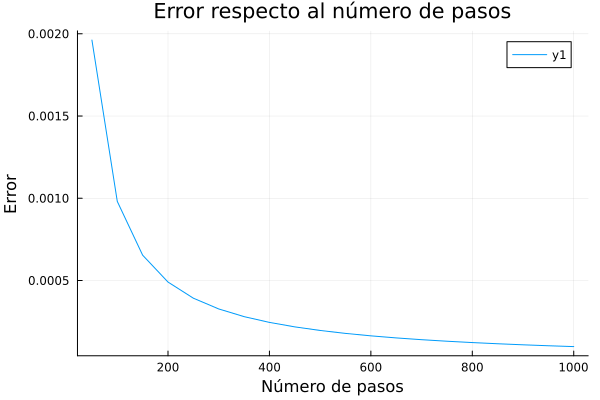

In [10]:
using Plots
plot(N, result_steps, title= "Error respecto al número de pasos", xlabel="Número de pasos", ylabel="Error")

### Evolución de un estado inicial para un t no fijo y número de pasos Cte

In [11]:
ns_1=100
delta_t1= 0.01
t_f1=0.2

states_t1= trotter_evolution(state, ns_1, delta_t1, t_f1)
states_t1_H= evolution_H(state, delta_t1, t_f1)

results_t1=[norm(states_t1[i]-states_t1_H[i]) for i in 1:Int(t_f1/delta_t1)]


20-element Vector{Float64}:
 1.0022905672275026e-5
 4.005100273275409e-5
 8.99939572940707e-5
 0.00015972228774238734
 0.0002490664202343996
 0.0003578145869864034
 0.00048570968366898185
 0.0006324452466828825
 0.000797660748228159
 0.0009809364357923416
 0.0011817879622948672
 0.0013996610633333672
 0.0016339265392918629
 0.0018838757930258938
 0.002148717159538827
 0.002427573243736171
 0.0027194794572549404
 0.003023383916896421
 0.0033381488366017193
 0.003662553513224531

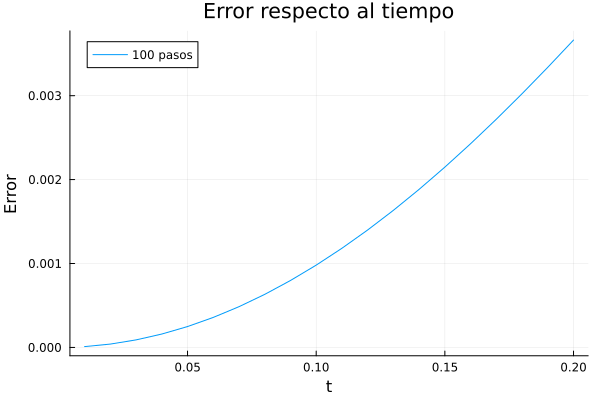

In [12]:
t1=0.01:0.01:0.2
plot(t1, results_t1, label= "100 pasos", title="Error respecto al tiempo", xlabel="t", ylabel="Error")



In [13]:
ns_2=200


states_t2= trotter_evolution(state, ns_2, delta_t1, t_f1)


results_t2=[norm(states_t2[i]-states_t1_H[i]) for i in 1:Int(t_f1/delta_t1)]


20-element Vector{Float64}:
 5.011460851674345e-6
 2.0025567346348618e-5
 4.499720529123818e-5
 7.98616848000248e-5
 0.00012453426236171486
 0.00017890908434828488
 0.00024285761051339315
 0.0003162265982363298
 0.0003988357467413069
 0.0004904751148968116
 0.0005909024358252117
 0.0006998404566191978
 0.0008169744320514427
 0.0009419498975031391
 0.0010743708391551079
 0.0012137983692364395
 0.001359750001592377
 0.0015116996084445706
 0.0016690781241319287
 0.0018312750455202285

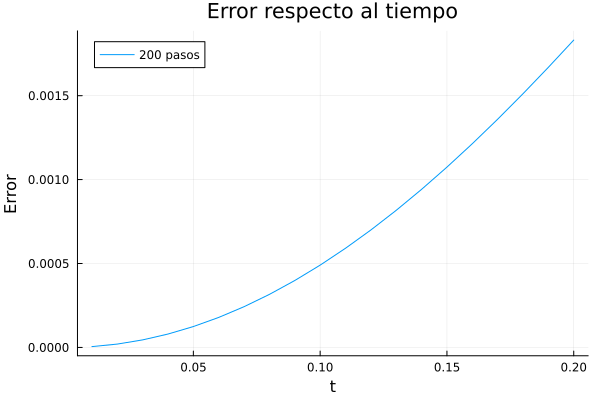

In [14]:
plot(t1, results_t2, label="200 pasos", title="Error respecto al tiempo", xlabel="t", ylabel= "Error")

### Evolución del sistema y valores esperados de las matrices de Pauli

In [15]:
delta_t= 0.1
ns=100
t_f=20

resultados = trotter_evolution(state, ns, delta_t, t_f)

resultados_H = evolution_H(state, delta_t, t_f)

200-element Vector{Any}:
 Complex[0.09626713663572352 + 0.01806353047160546im, 0.05259027500719988 - 0.0021631994154498874im, -0.015624398232309534 - 0.005048216524859077im, 0.006942761505558481 + 0.041408214681264974im, 0.014329080009211492 - 0.05625023288748867im, -0.007199730888558971 + 0.0400522060583747im, 0.03661582383197486 + 0.08912735076594369im, -0.0034372135085871795 + 0.09822078443969312im, 0.015848907026372195 - 0.0002635687024713164im, 0.006349288965362226 + 0.050488924073569474im  …  0.00020121087479420014 + 0.0103564598792298im, 0.026605481565151093 - 0.08477985791802806im, 0.020947088773489726 + 0.042434344542032466im, -0.04822486148591711 + 0.015090545538292418im, 0.022962964323229588 - 0.09496198463977061im, -0.029741001922627713 + 0.0721845438782262im, -0.01011461359138285 - 0.05613507337643835im, -0.006230063256138323 - 0.1315373076776812im, -0.0381582157557757 + 0.011404528008243372im, -0.0018184221186232953 - 0.07217085842580882im]
 Complex[0.01736225574434783 + 

#### Valores esparados $\sigma_z$

In [16]:
exp_val_z=valores_esperado(resultados, Z)

200-element Vector{Float64}:
  0.013383848965410117
 -0.006624146375989237
 -0.038511454099734665
 -0.0729897338352955
 -0.09939339133354697
 -0.10892749674662278
 -0.0974376398975913
 -0.0667730511543273
 -0.024261123792196193
  0.019557503629835715
  ⋮
  0.028337485533579343
 -0.0005438225443290534
 -0.032718270184758314
 -0.06089822608879031
 -0.0788242800515
 -0.0830581722624053
 -0.07390761754157699
 -0.05514908990232559
 -0.03262741475990982

In [17]:
exp_val_z_H=valores_esperado(resultados_H, Z)

200-element Vector{Float64}:
  0.013303085352718846
 -0.006919117980340561
 -0.039062373117973614
 -0.07370756599721406
 -0.10006806230748594
 -0.10928849361093546
 -0.09724696899919788
 -0.06591689337350232
 -0.022803954009572636
  0.02138013532752514
  ⋮
 -0.04366846513651457
 -0.018176239246214587
  0.012547121569534858
  0.044301249680471
  0.07195105293688264
  0.09029929472781056
  0.0952882688780366
  0.08521400718856231
  0.06153022855708845

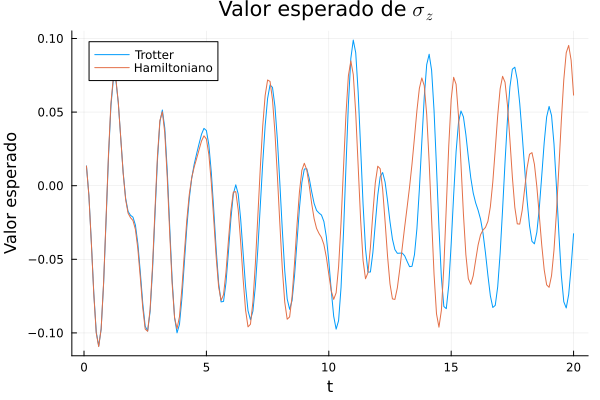

In [18]:
t=delta_t:delta_t:t_f

plot(t, exp_val_z, label="Trotter", title="Valor esperado de \$\\sigma_z\$ ", xlabel="t", ylabel="Valor esperado")
plot!(t, exp_val_z_H, label="Hamiltoniano", title= "Valor esperado de \$\\sigma_z\$ ", xlabel="t", ylabel="Valor esperado")

#### Valores esperados $\sigma_x$

In [19]:
exp_val_x= valores_esperado(resultados, X)
exp_val_x_H= valores_esperado(resultados_H, X)

200-element Vector{Float64}:
  0.09597007528202921
  0.10670233117808083
  0.09203887463889777
  0.058850016738596016
  0.014092021134346494
 -0.035508444201260474
 -0.08074283719558423
 -0.10922500459893378
 -0.10965604971087496
 -0.07857389518259196
  ⋮
 -0.055735746569953185
 -3.281537718925428e-5
  0.046980376733063385
  0.070965127389209
  0.06491305787048063
  0.03223696058335439
 -0.01409138095298032
 -0.05627061242377398
 -0.07799077230024244

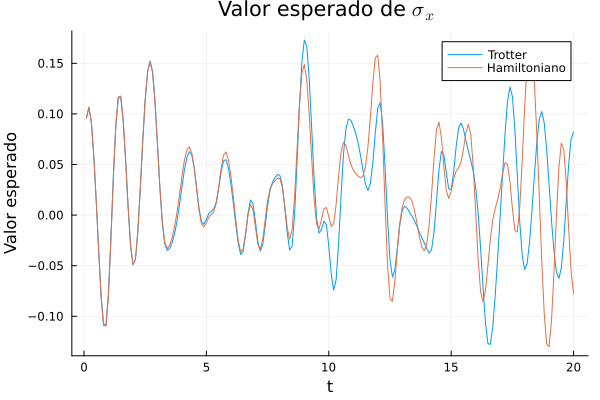

In [20]:
plot(t, exp_val_x, label="Trotter", title="Valor esperado de \$\\sigma_x\$ ", xlabel="t", ylabel="Valor esperado")
plot!(t, exp_val_x_H, label="Hamiltoniano", title= "Valor esperado de \$\\sigma_x\$ ", xlabel="t", ylabel="Valor esperado")


#### Valores esperados $\sigma_y$

In [21]:
exp_val_y= valores_esperado(resultados, Y)
exp_val_y_H= valores_esperado(resultados_H, Y)

200-element Vector{Float64}:
 -0.04303932151255603
 -0.09815463637926963
 -0.12566355905649648
 -0.11517551741861694
 -0.06766735290109295
  0.004346101325401361
  0.08045519981289095
  0.13871798799499577
  0.16264780358221614
  0.1464450097254004
  ⋮
  0.07789084258997359
  0.1025048911466643
  0.11442287314112892
  0.10928280382629235
  0.0850478365390873
  0.04351961576432289
 -0.008949586326418808
 -0.062147076922500134
 -0.10420733962387975

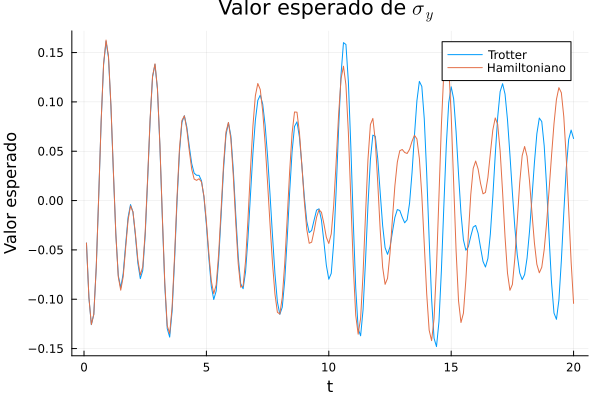

In [22]:
plot(t, exp_val_y, label="Trotter", title="Valor esperado de \$\\sigma_y\$ ", xlabel="t", ylabel="Valor esperado")
plot!(t, exp_val_y_H, label="Hamiltoniano", title= "Valor esperado de \$\\sigma_y\$ ", xlabel="t", ylabel="Valor esperado")